In [375]:
# Cargar librerías
import pandas as pd  # Manejo de dataframes
import numpy as np  # Manejo de arrays

In [376]:
# Cargar datos
df = pd.read_csv("data/df.csv", index_col=0)
df.head()

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,MaritalStatus,...,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,target,retirementDate,retirementType,resignationReason
EmployeeID,,,,,,,,,,,,,,,,,,,,,
1,51,Travel_Rarely,Sales,6,2,Life Sciences,Female,1,Healthcare Representative,Married,...,0,3.0,4.0,2.0,3,3,0,NaN,No,No
2,31,Travel_Frequently,Research & Development,10,1,Life Sciences,Female,1,Research Scientist,Single,...,4,3.0,2.0,4.0,2,4,1,2016-10-15,Resignation,Others
3,32,Travel_Frequently,Research & Development,17,4,Other,Male,4,Sales Executive,Married,...,3,2.0,2.0,1.0,3,3,0,NaN,No,No
4,38,Non-Travel,Research & Development,2,5,Life Sciences,Male,3,Human Resources,Married,...,5,4.0,4.0,3.0,2,3,0,NaN,No,No
5,32,Travel_Rarely,Research & Development,10,1,Medical,Male,1,Sales Executive,Single,...,4,4.0,1.0,3.0,3,3,0,NaN,No,No


In [377]:
# Quitar retirementDate, retirementType y retirementReason porque puede generar un sesgo en el modelo
df.drop(["retirementDate", "retirementType", "resignationReason"], axis=1, inplace=True)


# Reemplazar los valores nan de EnvironmentSatisfaction, JobSatisfaction y WorkLifeBalance por la moda de ese empleado en su departamento
df["EnvironmentSatisfaction"] = df.groupby("Department")[
    "EnvironmentSatisfaction"
].transform(lambda x: x.fillna(x.mode()[0]))

df["JobSatisfaction"] = df.groupby("Department")["JobSatisfaction"].transform(
    lambda x: x.fillna(x.mode()[0])
)
df["WorkLifeBalance"] = df.groupby("Department")["WorkLifeBalance"].transform(
    lambda x: x.fillna(x.mode()[0])
)


# Se categorizaron las variables numéricas que en realidad son categóricas
convert_dict = {
    "Education": str,
    "JobLevel": str,
    "StockOptionLevel": str,
    "EnvironmentSatisfaction": str,
    "JobSatisfaction": str,
    "WorkLifeBalance": str,
    "JobInvolvement": str,
    "PerformanceRating": str,
}
# Con el diccionario convertimos las variables a string
df = df.astype(convert_dict)

In [378]:
from sklearn.model_selection import train_test_split

# Separación de caracteristicas y target (X , y)
y = df.target
X = df.drop(["target"], axis=1)

# Separación en conjuntos de entrenamiento y validación con 90% de muestras para entrenamiento
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de validación:", X_test.shape)

# Seleccionar variables numéricas int64 y float64
numeric_columns = list(X.select_dtypes(include=["int64", "float64"]).columns)
categorical_columns = list(X.select_dtypes("object").columns)

Tamaño del conjunto de entrenamiento: (3943, 24)
Tamaño del conjunto de validación: (439, 24)


In [379]:
# Estandarizar las variables numéricas
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

# Convertir a dummy las variables categóricas
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# Modelos

In [422]:
# Lista de modelos que tienen más interpretabilidad para clasificación
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier  # Ensamble con bagging
from sklearn.ensemble import GradientBoostingClassifier  # Ensamble con boosting
from xgboost import XGBClassifier  # Ensamble con boosting

models = {
    "LogisticRegression": LogisticRegression(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "GradientBoostingClassifier": GradientBoostingClassifier(),
    "XGBClassifier": XGBClassifier(),
}

# Entrenar los modelos
for model in models:
    models[model].fit(X_train, y_train)

# Evaluar los modelos con validación cruzada con 5 folds y F1 como métrica
from sklearn.model_selection import cross_val_score

for model in models:
    scores = cross_val_score(
        models[model], X_train, y_train, cv=5, scoring="f1"
    )  # cv es el número de folds
    print(
        "F1: %0.3f (+/- %0.3f) [%s]" % (scores.mean(), scores.std(), model)
    )  # scores.mean() es el promedio de las métricas de cada fold

F1: 0.262 (+/- 0.034) [LogisticRegression]
F1: 0.940 (+/- 0.024) [DecisionTreeClassifier]
F1: 0.970 (+/- 0.017) [RandomForestClassifier]
F1: 0.507 (+/- 0.053) [GradientBoostingClassifier]
F1: 0.968 (+/- 0.019) [XGBClassifier]


# Mejor modelo

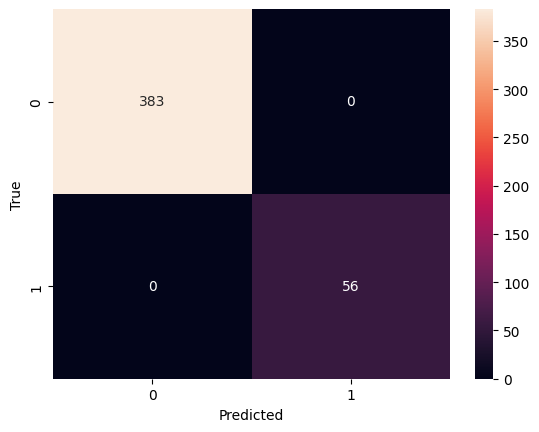

,Feature,Importance
62,JobInvolvement_1,0.059966
45,MaritalStatus_Single,0.033128
34,JobRole_Healthcare Representative,0.026188
11,BusinessTravel_Travel_Frequently,0.025846
61,WorkLifeBalance_4.0,0.024352
41,JobRole_Sales Executive,0.023021
54,JobSatisfaction_1.0,0.023005
50,EnvironmentSatisfaction_1.0,0.022201
21,EducationField_Human Resources,0.021531
65,JobInvolvement_4,0.021348


In [424]:
# Seleccionar el modelo con el mejor F1 en validación cruzada
best_model = XGBClassifier()
best_model.fit(X_train, y_train)

# Matriz de confusión y visualización con True y Predicted
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Tabla de características más importantes
importances = pd.DataFrame(
    {
        "Feature": X_train.columns,
        "Importance": best_model.feature_importances_,
    }
)
importances.sort_values(by="Importance", ascending=False).head(25)